# Ahead of using this notebook
---
### Pre-Processing raw plate reader outputs
---
The user provides his plate reader fluorescence files. These files go through a 2-steps process to be "active-learning"-ready:

* **Step 1:** generate a first dataframe with these columns: components concentrations, replicas well names, replicas measured fluorescence. [Example File](https://github.com/brsynth/icfree-ml/blob/yorgo/tests/data/active_learning/input/experimental_data/raw_all_fluorescence.csv)

* **Step 2:** generate a second dataframe with these columns: components concentrations (X_data), mean of replicas measured fluorescence (y_data), std of replicas measured fluorescence data (y_data_std). [Example File](https://github.com/brsynth/icfree-ml/blob/yorgo/tests/data/active_learning/input/experimental_data/plate_AL_1_fluorescence_and_std.csv)

**Notice**
- Currently, the formatting process is conducted manually, the plan is to implement a "pre-processing" function that automates the above-mentioned steps.

- **Bottelnecks:** plate reader outputs are not universal and mutliple fluorescence gains could be reported in a single file which makes parsing case-specific. The user will still need to manually extract and store in a file the measured fluorescence he wishes to study. That file would go through the above-mentioned steps.


In [1]:
#!/usr/bin/env python
# coding: utf-8

from os import (
    path as os_path,
    mkdir as os_mkdir
)

from csv import (
    DictWriter as csv_DictWriter
)

from typing import (
    List
)

import numpy as np
import copy

from pandas import (
    read_csv as pd_read_csv,
    DataFrame
)

import matplotlib.pyplot as plt

from sklearn.metrics import (
    r2_score
)

from sklearn.neural_network import (
    MLPRegressor
)

# from icfree.plates_generator.plates_generator import (
#     input_importer,
#     input_processor,
#     doe_levels_generator,
#     levels_to_concentrations
# )

# Active Learning Workflow
---

### **Step 1:** provide a data folder and the number of files you wish to merge together to generate a training dataset.

In [2]:
def dataset_generator(
        data_folder: str,
        files_number: int
):
    """
    Merge experimental data into a single dataset

    Parameters
    ----------
        data_folder: str
            Path to folder with experimental data
        files_number: int
            Number of files to be merged into a single dataset

    Returns
    -------
        dataset: ndarray
            Array with all experimental data
    """
    # Read file(s) and store in dataframe(s)
    experimental_data = [pd_read_csv(
        data_folder.format(i))
        for i in range(1, files_number + 1)]

    # Concatenate all dataframes
    dataset = np.concatenate(
        experimental_data,
        axis=0)

    return dataset

# Call function
data_folder = 'experimental_data_borkowski_et_al/plate_AL_{}_raw_yield_and_std.csv'
files_numbers = 3
dataset = dataset_generator(data_folder, files_numbers)

### **Step 2:** the training dataset is processed to extract elements: y_data, y_std_data, X_data and max_X_data

In [3]:
def dataset_processor(dataset):
    """
    Extract X and Y data

    Parameters
    ----------
        dataset: ndarray
            Array with all experimental data

    Returns
    -------
        X_data: ndarray
            Array of X_data
        y_data: ndarray
            Array of mean y_data
        y_std_data: ndarray
            Array of standard deviation of y_data
        max_X_data: List
            List of maximum X_data values
    """
    # Extract X_data
    X_data = dataset[:, 0:11]

    # Extract y_data
    y_data = dataset[:, 11]

    # Extract y_std_data
    y_std_data = dataset[:, 12]

    # Extract maximimum X_data values for nomalisation
    max_X_data = []
    for i in range(X_data.shape[1]):
        max_X_data.append(
            copy.deepcopy(
                max(X_data[:, i])))
        X_data[:, i] = X_data[:, i]/max(X_data[:, i])

    return (X_data,
            y_data,
            y_std_data,
            max_X_data)

# Call function
X_data, \
y_data, \
y_std_data, \
max_X_data = dataset_processor(dataset)

### **Step 3:** generate an esemble of pre-trained regressor models. In the case of multi-layer perceptrons, a selection process is applied while building the ensemble.

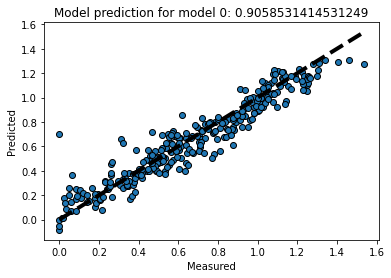

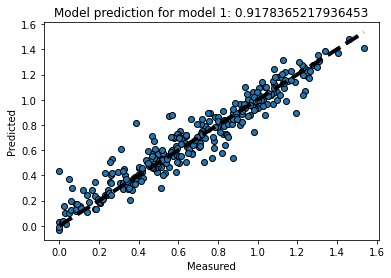

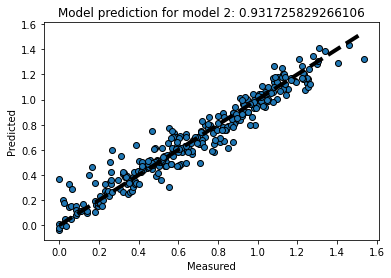

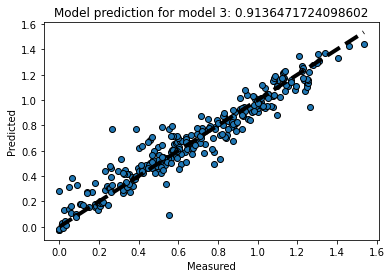

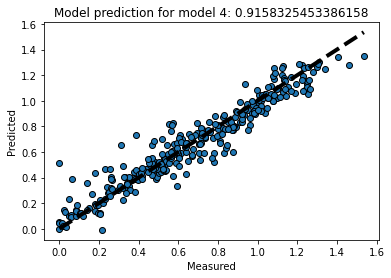

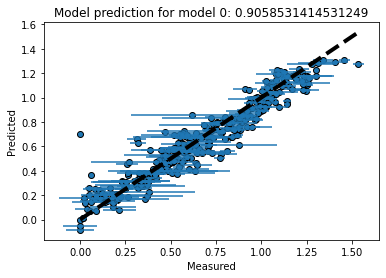

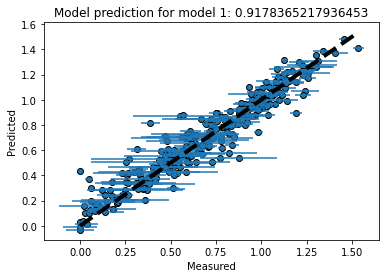

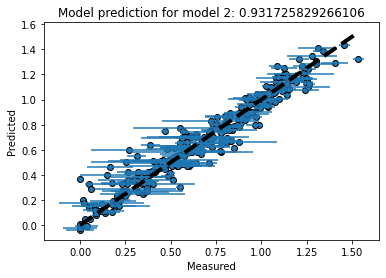

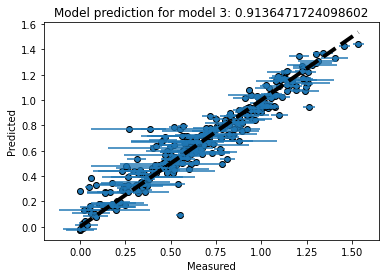

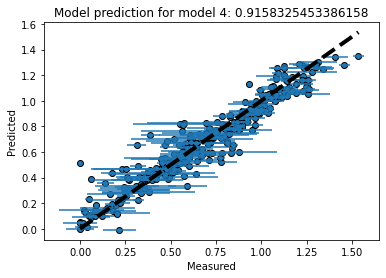

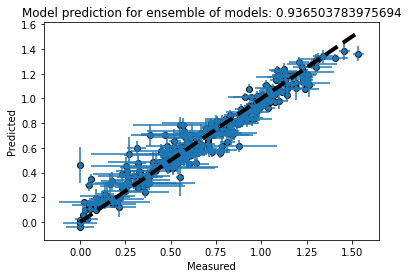

In [4]:
def create_single_regressor(
    X_data,
    y_data,
    model_name: str,
    models_number: int
):
    """
    Train and select regressor models with different hidden layers sizes

    Parameters
    ----------
        X_data: ndarray
            Array of X_data
        y_data: ndarray
            Array of mean y_data
        models_number: int
            Number of models to create
        model_name: str
            Name of the model

    Returns
    -------
        best_model: MLPRegressor
            Multi-layer Perceptron regressor
        best_score: numpy.float64
            Coefficient of determination (r2 score)
    """
    # Train the models
    trained_models = []
    for i in range(models_number):
        X_train = X_data
        y_train = y_data

        regressor1 = MLPRegressor(
                hidden_layer_sizes=(10, 100, 100, 20),
                activation="relu",
                solver="adam",
                max_iter=20000,
                early_stopping=True,
                learning_rate="adaptive")
        regressor1.fit(X_train, y_train.flatten())
        trained_models.append(regressor1)

        regressor2 = MLPRegressor(
                hidden_layer_sizes=(20, 100, 100, 10),
                activation="relu",
                solver="adam",
                max_iter=20000,
                early_stopping=True,
                learning_rate="adaptive")
        regressor2.fit(X_train, y_train.flatten())
        trained_models.append(regressor2)

        regressor3 = MLPRegressor(
                hidden_layer_sizes=(100, 50, 50, 40),
                activation="relu",
                solver="adam",
                max_iter=20000,
                early_stopping=True,
                learning_rate="adaptive")
        regressor3.fit(X_train, y_train.flatten())
        trained_models.append(regressor3)

        regressor4 = MLPRegressor(
                hidden_layer_sizes=(40, 50, 50, 100),
                activation="relu",
                solver="adam",
                max_iter=20000,
                early_stopping=True,
                learning_rate="adaptive")
        regressor4.fit(X_train, y_train.flatten())
        trained_models.append(regressor4)

    # Evaluate the output of the models
    all_scores = []
    for i in range(len(trained_models)):
        y_pred = trained_models[i].predict(X_data)
        score = r2_score(y_data, y_pred)
        all_scores.append(score)
    try:
        best_index = all_scores.index(max(all_scores))
        best_score = all_scores[best_index]
    except ValueError:
        best_index = 0
    best_model = trained_models[best_index]

    # Visualize the output of the model
    model = best_model
    y_pred = model.predict(X_data)
    score = r2_score(y_data, y_pred)
    fig, ax = plt.subplots()
    ax.scatter(y_data, y_pred, edgecolors=(0, 0, 0))
    ax.plot(
        [y_data.min(), y_data.max()],
        [y_data.min(), y_data.max()], 'k--', lw=4)
    ax.set_xlabel("Measured")
    ax.set_title(
        "Model prediction for model {}: {}".format(model_name, score))
    ax.set_ylabel("Predicted")
    plt.show()

    return (best_model, best_score)

def create_ensemble_regressor(
        X_data,
        y_data,
        y_std_data,
        ensemble_size: int
):
    """
    Generate a list of pre-trained regressor models

    Parameters
    ----------
        X_data: ndarray
            Array of X_data
        y_data: ndarray
            Array of mean y_data
        y_std_data: ndarray
            Array of standard deviation of y_data
        ensemble_size: int
            Number of regressor models to add in the ensemble

    Returns
    -------
        MLP_ensemble: List
            List of pre-trained regressor models
    """
    # Train the ensemble of models
    MLP_ensemble = []
    for i in range(ensemble_size):
        model, score = create_single_regressor(
            X_data,
            y_data,
            models_number=10,
            model_name=i)
        MLP_ensemble.append(model)

    # Evaluate and visualize the ouputs of models
    for i in range(len(MLP_ensemble)):
        model = MLP_ensemble[i]
        y_pred = model.predict(X_data)
        score = r2_score(y_data, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(y_data, y_pred, edgecolors=(0, 0, 0))
        ax.errorbar(y_data, y_pred, xerr=y_std_data, ls="none")
        ax.plot(
            [y_data.min(), y_data.max()],
            [y_data.min(), y_data.max()],
            "k--",
            lw=4)
        ax.set_xlabel("Measured")
        ax.set_title("Model prediction for model {}: {}".format(i, score))
        ax.set_ylabel("Predicted")
        plt.show()

    all_predictions = None
    for model in MLP_ensemble:
        y_pred = model.predict(X_data)
        # answer_array_pred = y_pred.reshape(X_data.shape[0], -1)
        if all_predictions is None:
            all_predictions = y_pred.reshape(X_data.shape[0], -1)
        else:
            all_predictions = np.concatenate((
                all_predictions,
                y_pred.reshape(
                    X_data.shape[0],
                    -1)),
                axis=1)

    y_pred = np.mean(all_predictions, axis=1)
    y_pred_std = np.std(all_predictions, axis=1)
    score = r2_score(y_data, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(y_data, y_pred, edgecolors=(0, 0, 0))
    ax.errorbar(y_data, y_pred, xerr=y_std_data, yerr=y_pred_std, ls="none")
    ax.plot(
            [y_data.min(), y_data.max()],
            [y_data.min(), y_data.max()],
            'k--',
            lw=4)
    ax.set_xlabel("Measured")
    ax.set_title("Model prediction for ensemble of models: {}".format(score))
    ax.set_ylabel("Predicted")
    plt.show()

    return MLP_ensemble

# Call function
MLP_ensemble = create_ensemble_regressor(
        X_data,
        y_data,
        y_std_data,
        ensemble_size=5)

### **Step 4:** select new samples to test from a pool of samples using a set of pre-trained models while avoiding duplicates

In [6]:
def check_samples(
    new_sample,
    array_to_avoid,
    size: int
):
    """
    Check if a sample is present in an array

    Parameters
    ----------
    new_sample: ndarray
        Array of samples to generate
    array_to_avoid: ndarray
        Array of samples to avoid duplicating
    size: int
        Number of elements in each sample

    Returns
    -------
    present: bool
        True if the sample is present in the array, False otherwise
    index: int
        Index of the sample in the array
    """
    present = False
    new_sample = np.reshape(np.array(new_sample), (1, size))
    for index in range(array_to_avoid.shape[0]):
        if np.array_equiv(
            array_to_avoid[index, :],
                new_sample):
            present = True
            break
    return(present, index)

# Maximum concentrations for each component
extract_max = 30
mg_gluta_max = 4
K_gluta_max = 80
aa_max = 1.5
peg_max = 2
hepes_max = 50
trna_max = 0.2
coa_max = 0.26
nad_max = 0.33
camp_max = 0.75
folinic_acid_max = 0.068
spemidine_max = 1
pga_max = 30
nucleo_mix_max = 1.5
DNA_max = 50
promoter_max = 10
RBS_max = 10

# Tested concentrations ratios for each component
mg_gluta_conc = [0.1, 0.3, 0.5, 1]
K_gluta_conc = [0.1, 0.3, 0.5, 1]
aa_conc = [0.1, 0.3, 0.5, 1]
trna_conc = [0.1, 0.3, 0.5, 1]
coa_conc = [0.1, 0.3, 0.5, 1]
nad_conc = [0.1, 0.3, 0.5, 1]
camp_conc = [0.1, 0.3, 0.5, 1]
folinic_acid_conc = [0.1, 0.3, 0.5, 1]
spermidine_conc = [0.1, 0.3, 0.5, 1]
pga_conc = [0.1, 0.3, 0.5, 1]
nucleo_conc = [0.1, 0.3, 0.5, 1]

def generate_random_grid(
    array_to_avoid,
    samples_number: int,
    normalisation: str
):
    """
    Generate a random array of samples

    Parameters
    ----------
    array_to_avoid: ndarray
        Array of samples to avoid duplicating
    samples_number: int
        Number of samples to generate
    normalisation: str
        True if the samples are to be normalised, False otherwise

    Returns
    -------
        active_learning_array: ndarray
            Array of samples
    """
    active_learning_array = None
    generated_samples_number = 0
    while generated_samples_number < samples_number:
        samples_levels = np.random.randint(
            0,
            high=4,
            size=11,
            dtype='int')

        if normalisation is True:
            samples_concentrations = [
                nad_conc[samples_levels[0]],
                folinic_acid_conc[samples_levels[1]],
                coa_conc[samples_levels[2]],
                nucleo_conc[samples_levels[3]],
                spermidine_conc[samples_levels[4]],
                pga_conc[1],
                aa_conc[samples_levels[6]],
                trna_conc[samples_levels[7]],
                mg_gluta_conc[samples_levels[8]],
                camp_conc[samples_levels[9]],
                K_gluta_conc[samples_levels[10]]
                ]
        else:
            samples_concentrations = [
                nad_conc[samples_levels[0]] * nad_max,
                folinic_acid_conc[samples_levels[1]] * folinic_acid_max,
                coa_conc[samples_levels[2]] * coa_max,
                nucleo_conc[samples_levels[3]] * nucleo_mix_max,
                spermidine_conc[samples_levels[4]] * spemidine_max,
                pga_conc[1] * pga_max,
                aa_conc[samples_levels[6]] * aa_max,
                trna_conc[samples_levels[7]] * trna_max,
                mg_gluta_conc[samples_levels[8]] * mg_gluta_max,
                camp_conc[samples_levels[9]] * camp_max,
                K_gluta_conc[samples_levels[10]] * K_gluta_max
                ]
        samples_concentrations = np.reshape(
            samples_concentrations,
            (1, 11))

        if not check_samples(
            samples_concentrations,
            array_to_avoid,
            size=11)[0]:
            generated_samples_number = generated_samples_number + 1

            if active_learning_array is None:
                active_learning_array = samples_concentrations
            else:
                active_learning_array = np.concatenate(
                    (active_learning_array,
                        samples_concentrations),
                    axis=0)
            array_to_avoid = np.concatenate(
                (array_to_avoid,
                    samples_concentrations),
                axis=0)
    return active_learning_array

In [7]:
def ensemble_model_predictions_selector(
    ensemble_of_models: List,
    array_to_avoid,
    pool_size: int,
    samples_number: int,
    exploitation: int,
    exploration: float,
    normalisation: str,
    max_X_data: List[float],
    verbose: str
):
    """
    Select new samples to test from a pool of samples using a set of pre-trained models

    Parameters
    ----------
        ensemble_of_models: List
            List of pre-trained models
        array_to_avoid: ndarray
            Array of samples to avoid sampling again
        pool_size: int
            Total number of samples in the pool
        samples_number: int
            Number of samples to select and export
        exploitation: int
            Coefficient of focus on higher y_data query
        exploration: float
            Coefficient of focus on a more informative query
        normalisation: str
            True if the samples are to be normalised, False otherwise
        max_X_data: List
            List of maximum X_data values
        verbose: str
            If True, print progress. If False, don't print progress.

    Returns
    -------
        conditions_to_test: ndarray
            Array to maximise y_data and y_std_data
        conditions_to_test_exploration: ndarray
            Array to maximise y_std_data
        conditions_to_test_exploitation: ndarray
            Array to maximise y_data
    """
    # Tested X_data
    active_learning_array = generate_random_grid(
        array_to_avoid,
        samples_number=pool_size,
        normalisation=normalisation)

    # Predicted X_data
    all_predictions = None
    for model in ensemble_of_models:
        y_pred = model.predict(active_learning_array)
        if all_predictions is None:
            all_predictions = y_pred.reshape(
                active_learning_array.shape[0],
                -1)
        else:
            all_predictions = np.concatenate(
                (all_predictions,
                 y_pred.reshape(
                     active_learning_array.shape[0],
                     -1)),
                axis=1)

    # Compute mean of the predicted array
    y_pred = np.mean(
        all_predictions,
        axis=1)

    # Compute std of the predicted array
    y_pred_std = np.std(
        all_predictions,
        axis=1)

    # Array to maximise, while balancing between exploration and exploitation
    array_to_maximise = copy.deepcopy(
        exploitation * y_pred + exploration * y_pred_std)

    # Select arrays in regards of the exploration method
    # Select arrays in regards of y_pred only
    conditions_list_exploitation = []
    for count in range(samples_number):
        i = np.argmax(y_pred)
        conditions_list_exploitation.append(int(i))
        if verbose:
            print(
                "Maximising sample {} is yield: {}, std = {}".format(
                    i,
                    y_pred[i],
                    y_pred_std[i])
            )
        y_pred[i] = -1

    # Select arrays in regards of y_pred_std only
    conditions_list_exploration = []
    for count in range(samples_number):
        i = np.argmax(y_pred_std)
        conditions_list_exploration.append(int(i))
        if verbose:
            print(
                "Maximising sample {} is yield: {}, std = {}".format(
                    i,
                    y_pred[i],
                    y_pred_std[i])
            )
        y_pred_std[i] = -1

    # Select arrays in regards of both y_pred and y_pred_std
    conditions_list = []
    for count in range(samples_number):
        i = np.argmax(array_to_maximise)
        conditions_list.append(int(i))
        if verbose:
            print(
                "Maximising sample {} is yield: {}, std = {}".format(
                    i,
                    y_pred[i],
                    y_pred_std[i])
            )
        array_to_maximise[i] = -1

    # Normalise X_data values
    if normalisation is True:
        for i in range(active_learning_array.shape[1]):
            active_learning_array[:, i] = \
                active_learning_array[:, i] * max_X_data[i]
    # Don't normalise X_data values
    else:
        active_learning_array = active_learning_array

    # Generate conditions to test exploration and exploitation
    conditions_to_test = active_learning_array[conditions_list, :]

    # Generate conditions to test exploration
    conditions_to_test_exploration = \
        active_learning_array[conditions_list_exploration, :]

    # Generate conditions to test exploitation
    conditions_to_test_exploitation = \
        active_learning_array[conditions_list_exploitation, :]

    return(
        conditions_to_test,
        conditions_to_test_exploration,
        conditions_to_test_exploitation
        )

# Call function
conditions_to_test, \
conditions_to_test_exploration, \
conditions_to_test_exploitation = \
ensemble_model_predictions_selector(
    ensemble_of_models=MLP_ensemble,
    array_to_avoid=X_data,
    pool_size=1000,
    samples_number=500,
    exploitation=1,
    exploration=1.41,
    normalisation=True,
    max_X_data=max_X_data,
    verbose=False
    )

### **Step 5:** post-process and save generated dataframes samples to fit as echo instructor input

In [8]:
def save_conditions_to_test(
    array,
    output_file
):
    """
    Save arrays in CSV files

    Parameters
    ----------
    array: ndarray
        Array to save
    output_file: str
        Path to output file
    """
    fieldnames = [
        "nad", "folinic_acid", "DNA", "coa", "RBS", "peg", "nucleo_mix",
        "spermidin", "pga", "aa", "trna", "mg_gluta", "hepes", "camp",
        "K_gluta", "promoter"]
    export_as_list = []

    for row in array:
        new_dict = {}
        new_dict["nad"] = round(float(row[0]), 5)
        new_dict["folinic_acid"] = round(float(row[1]), 5)
        new_dict["DNA"] = 50
        new_dict["coa"] = round(float(row[2]), 5)
        new_dict["RBS"] = 10
        new_dict["peg"] = 2
        new_dict["nucleo_mix"] = round(float(row[3]), 5)
        new_dict["spermidin"] = round(float(row[4]), 5)
        new_dict["pga"] = round(float(row[5]), 5)
        new_dict["aa"] = round(float(row[6]), 5)
        new_dict["trna"] = round(float(row[7]), 5)
        new_dict["mg_gluta"] = round(float(row[8]), 4)
        new_dict["hepes"] = 50
        new_dict["camp"] = round(float(row[9]), 4)
        new_dict["K_gluta"] = round(float(row[10]), 4)
        new_dict["promoter"] = 10
        export_as_list.append(new_dict)

    with open(output_file, "w") as csv_handle:
        csv_writer = csv_DictWriter(
            csv_handle,
            fieldnames,
            restval='',
            extrasaction='ignore')
        csv_writer.writeheader()
        for result in export_as_list:
            csv_writer.writerow(result)

# Call function
basename = "conditions_to_test"
save_conditions_to_test(
    conditions_to_test,
    output_file = "{}.csv".format(basename))
save_conditions_to_test(
    conditions_to_test_exploration,
    output_file = "{}_exploration.csv".format(basename))
save_conditions_to_test(
    conditions_to_test_exploitation,
    output_file = "{}_exploitation.csv".format(basename))

## Improvements
---
- Extracting elements from the training dataset should be more generic; independant from the shape of the dataframe.
- Implement functions from the "plates generator module" to generate samples instead of using new functions here.
- Just like plates generator and echo instructor, the user should be able to provide his parameter, maximum concentrations and ratios in files instead of writing them directly here.